## Блок импорта ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

## Загрузка данных ##

Как полагается, буду использовать классический для себя сет из sklearn.

In [2]:
df = make_blobs(n_samples = 50, n_features = 2, centers = 3)

In [3]:
X, y = df

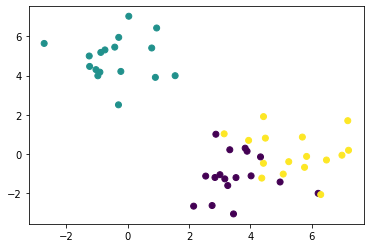

In [4]:
plt.scatter(X[:,0], X[:, 1], c = y)

## Реализация алгоритма ##

Реализовал нахождение центров кластеров. При необходиомсти можно и само разделение сделать.

In [5]:
class Agglomerative_clustering(object):
    def __init__(self, n_clusters: int = 3, metric: str = 'mse'):
        assert (metric in ('mse','rmse','me','mae')), 'metric can take only values from (\'mse\', \'rmse\', \'me\', \'mae\')'
        self.n_clusters = n_clusters
        
        self.metrics = {'mse': self.mse,'rmse': self.rmse,'me': self.me, 'mae': self.mae}
        self.metric = self.metrics[metric]
        
    def mse(self, a: list or np.array, b: list or np.array) -> float:
        """
        Возвращает mean squared error.
        _________
        Параметры
        _________
        a,b: list or np.array
        """
        a = np.array(a)
        b = np.array(b)
        return np.average( ( a - b ) **2 )

    def rmse(self, a: list or np.array, b: list or np.array) -> float:
        """
        Возвращает корень из mean squared error.
        _________
        Параметры
        _________
        a,b: list or np.array
        """
        a = np.array(a)
        b = np.array(b)
        return np.average( ( a - b ) **2 )**.5

    def me(self, a: list or np.array, b: list or np.array) -> float:
        """
        Возвращает mean error.
        Может выйти в ноль за счет компенсации 
        положительными и отрицательными значениями, 
        одинаковыми по модулю, но разными по знаку, 
        поэтому не используется вообще.
        _________
        Параметры
        _________
        a,b: list or np.array
        """
        a = np.array(a)
        b = np.array(b)
        return np.average( a - b )

    def mae(self, a: list or np.array, b: list or np.array) -> float:
        """
        Возвращает mean absolute error.
        _________
        Параметры
        _________
        a,b: list or np.array
        """
        a = np.array(a)
        b = np.array(b)
        return np.average( np.abs(a - b) )
    
    def create_new_cluster(self, X, old_elem_idx, new_elem_idx, weights):
        # создать новый кластер со значениями - средними значениями элементов
        temp = np.column_stack([X[old_elem_idx], X[new_elem_idx]])
        return np.average(temp, axis = 1, weights=weights)
        
    def delete_old_elems(self, X, elem_idx):
        return np.delete(X, elem_idx, axis = 0)
    
    def calculate_distances(self, X):
        distances = []
        # для каждой точки
        for idx_cp, current_point in enumerate(X):
            cp_ne_dist = []
            # считаем расстояния до каждой другой точки
            # на первой итерации индексы - это просто номера, а потом они станут номерами классов
            for idx_ne, neighbor in enumerate(X): # чтобы запомнить, где какая точка, нужно их пронумеровать
                # здесь - от конкретной точки current_point до всех остальных точек
                cp_ne_dist.append([idx_cp, idx_ne, self.metric(current_point, neighbor)])

            cp_ne_dist = sorted(cp_ne_dist, key = lambda x: x[2]) # нулевой элемент - номер, первый - расстояние

            # ниже - копим все точки в одной матрице с отсортированными расстояниями
            distances.append(cp_ne_dist.copy())
        return distances
    
    def find_min(self, dst):
        min_d = [0, 0, 1e10]
        for dist_mas in dst:
            for dist in dist_mas:
                if ( ( dist[2] != 0 ) and ( dist[2] < min_d[2] ) ):
                    # условие - дистанция != 0, т.е. точка не является самой собой
                    # и условие на нахождение минимума
                    min_d = dist
        # вернется массив [от точки, до точки, расстояние]
        return min_d

    def fit_predict(self, X):
        """
        Нужно посчитать матрицы расстояний 
        от каждой точки до каждой и соединять 
        точки в классы до тех пор, пока количество классов 
        не совпадет с изначальным
        """
        count = 1
        # инициализация текущего количества кластеров
        n_clusters_current = X.shape[0]
        
        # поочередно объединяем, пока количество кластеров не совпадет
        while (n_clusters_current != self.n_clusters):
            # на каждом шаге будет считаться новый кластер и 
            # удаляться старые элементы (члены нового кластера) из набора данных

            # на каждом шаге классы будут меняться и сам df будет меняться, 
            # так что матрицу расстоний придется каждый раз пересчитывать заново
            distances = self.calculate_distances(X)
            
            # найти два самых близких элемента
            min_pair = self.find_min(distances)
            # на более поздних шагах - элементы это уже не точки, а кластеры
            
            # объединим их в один кластер и добавим кластер в набор данных
            X = np.append(X, self.create_new_cluster(X, min_pair[0], min_pair[1], weights = [1, 1/count])).reshape(-1,2)
            # веса новых элементов во вкладе в класетры постепенно уменьшаются, поскольку элементов 
            # в кластере на каждой итерации становится все больше
            
            # удалим из набора данных точки кластера по-отдельности, чтобы не было повторений
            if (min_pair[0] > min_pair[1]):
                # так как возвращается новый массив,
                # то у него индексы сдвинуты на единицу 
                # в зависимости от положения удаленного индекса
                X = self.delete_old_elems(X, min_pair[0])
                X = self.delete_old_elems(X, min_pair[1])
            elif (min_pair[1] > min_pair[0]):
                X = self.delete_old_elems(X, min_pair[1])
                X = self.delete_old_elems(X, min_pair[0])
            else:
                X = self.delete_old_elems(X, min_pair[0])
            
            count += 1
            n_clusters_current -= 1

            #yield X
        
        clusters_centers = X
        return clusters_centers

In [6]:
ac = Agglomerative_clustering(n_clusters=3, metric='rmse')
cl = ac.fit_predict(X)

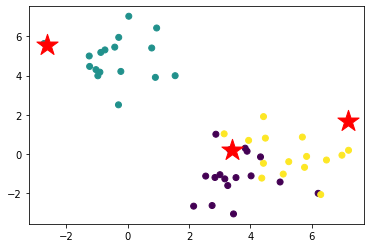

In [7]:
plt.scatter(X[:,0], X[:, 1], c = y, marker='o')
plt.scatter(cl[:,0], cl[:, 1], marker = '*', color = 'red', s = 500)

## Проверка ##

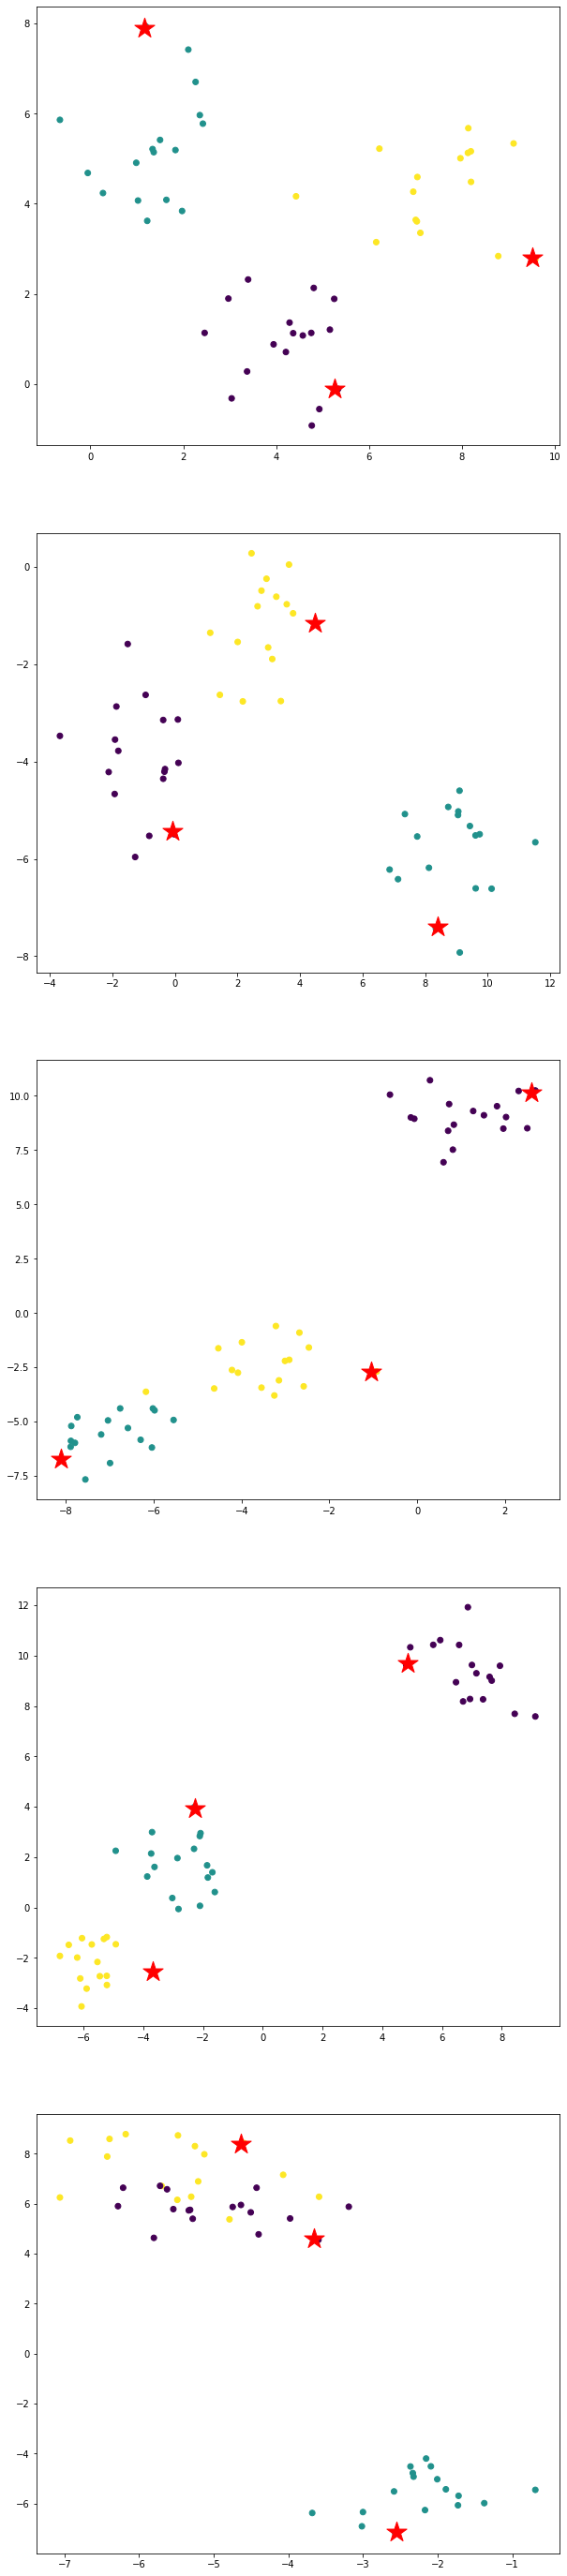

In [8]:
n = 5
fig, ax = plt.subplots(n,1, figsize = (10,n*10))

for idx in range(n):
    clusters_ = 3
    df = make_blobs(n_samples = 50, n_features = 2, centers = clusters_)
    X, y = df
    ax[idx].scatter(X[:,0], X[:, 1], c = y)
    ac = Agglomerative_clustering(n_clusters = clusters_, metric = 'mse')
    cl = ac.fit_predict(X)
    ax[idx].scatter(cl[:,0], cl[:, 1], marker = '*', color = 'red', s = 500)